## Data import

In [117]:
# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

AA_df = pd.read_csv("Data S1.csv", encoding="utf-8") 

# Define amino acid list once at the top
amino_acids = ['Ser','Lys', 'Met', 'Phe', 'Leu', 'Thr', 'Val', 'Trp','Arg', 'Gln', 'Gly', 'Tyr','Asn', 'Ala','Tau','Orn']

In [118]:
AA_df = AA_df.dropna(subset=['pTNM stage'] + amino_acids)

In [119]:
AA_df

,Sample,Tau,Lys,Asn,Arg,Met,Gln,Orn,Phe,Leu,...,pN,pM,Number of positive lymph nodes,Number of harvested lymph nodes,Tumor size (cm),Histologic grade,Lymphovascular invasion,Perineural invasion,Last follow-up date,Recurrence
0,Patient-1,97.411,103.533,31.423,0.000,15.808,197.833,31.726,37.455,93.192,...,0.0,0.0,0.0,46.0,1.7,Well-differentiated,No invasion,No invasion,NaN,NaN
1,Patient-2,73.993,70.206,21.191,0.000,0.000,367.578,0.000,27.415,238.829,...,0.0,0.0,0.0,15.0,3.8,Moderately differentiated,No invasion,No invasion,NaN,NaN
2,Patient-3,65.505,90.469,0.000,0.000,0.000,181.527,0.000,16.784,89.368,...,0.0,0.0,0.0,12.0,0.8,Moderately differentiated,No invasion,No invasion,NaN,NaN
3,Patient-4,42.170,77.167,0.000,41.121,0.000,192.521,13.172,21.775,30.512,...,0.0,0.0,0.0,57.0,8.8,Moderately differentiated,No invasion,No invasion,NaN,NaN
4,Patient-5,128.726,139.303,39.297,54.231,48.967,356.260,63.024,34.642,133.589,...,1.0,0.0,1.0,46.0,9.8,Moderately differentiated,No invasion,No invasion,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,Patient-148,124.315,172.431,0.000,58.213,28.906,367.515,103.372,77.159,144.639,...,0.0,0.0,0.0,30.0,5.7,Moderately differentiated,Lymphovascular invasion,No invasion,2022-05-22,Yes
148,Patient-149,152.506,131.335,43.920,29.851,27.922,415.112,118.936,64.782,120.672,...,NaN,NaN,NaN,NaN,NaN,Mucinous,NaN,NaN,NaN,NaN
149,Patient-150,119.279,207.649,90.775,62.947,51.336,678.529,93.942,64.417,107.694,...,2.0,1.0,18.0,18.0,12.0,Poorly differentiated,Lymphovascular invasion,No invasion,2019-05-23,Yes
150,Patient-151,0.000,53.241,0.000,16.388,0.000,137.560,11.158,14.486,21.526,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-08,Yes


## Data Pre-processing

In [120]:
## Data Pre-processing
target_amino_acids = amino_acids + ['Ile+Glu']
AA_df['Total'] = AA_df[target_amino_acids].sum(axis=1)
for aa in amino_acids:
    AA_df[f'{aa}_ratio'] = AA_df[aa] / AA_df['Total']
    AA_df[f'log1p_{aa}_ratio'] = np.log1p(AA_df[f'{aa}_ratio'])
scaler = StandardScaler()
zscore_columns = [f'zscore_log1p_{aa}_ratio' for aa in amino_acids]
AA_df[zscore_columns] = scaler.fit_transform(AA_df[[f'log1p_{aa}_ratio' for aa in amino_acids]])


## Correlation pair

In [121]:
from scipy.stats import t

# Function to calculate p-value from Pearson correlation coefficient and sample size
def calculate_p_value(r, n):
    if n <= 2 or abs(r) == 1:  # Insufficient degrees of freedom or perfect correlation
        return 0.0
    t_stat = abs(r) * np.sqrt((n - 2) / (1 - r**2))
    p_value = 2 * (1 - t.cdf(t_stat, df=n - 2))
    return p_value

# Dictionary to store significant correlations for each stage
grouped_significant_results = {}
AA_df["pTNM stage"] = AA_df["pTNM stage"].astype(int)

# Identify significant correlations for each pTNM stage
for stage in sorted(AA_df['pTNM stage'].unique()):
    stage_data = AA_df[AA_df['pTNM stage'] == stage][zscore_columns]
    correlation_matrix = stage_data.corr(method='pearson')
    sample_size = stage_data.shape[0]

    significant_pairs = set()
    for i, var1 in enumerate(correlation_matrix.columns):
        for j, var2 in enumerate(correlation_matrix.columns):
            if i < j:
                if "Ile+Glu" in var1 or "Ile+Glu" in var2:
                    continue  # Exclude pairs containing 'Ile+Glu'
                r = correlation_matrix.iloc[i, j]
                if abs(r) > 0.5:  # Correlation threshold
                    p_value = calculate_p_value(r, sample_size)
                    if p_value < 0.05:  # Significance threshold
                        pair = tuple(sorted((var1, var2)))
                        significant_pairs.add((pair[0], pair[1], r, p_value))

    grouped_significant_results[stage] = list(significant_pairs)  # Keep stage as integer

# Convert results to DataFrame
df_list = []
for stage, pairs in grouped_significant_results.items():
    if pairs:
        df_temp = pd.DataFrame(pairs, columns=["Variable 1", "Variable 2", "Correlation", "p_value"])
        df_temp["pTNM stage"] = stage
        df_list.append(df_temp)

result_df = pd.concat(df_list, ignore_index=True)

# Separate stage-specific DataFrames
stage1_df = result_df[result_df["pTNM stage"] == 1].reset_index(drop=True)
stage2_df = result_df[result_df["pTNM stage"] == 2].reset_index(drop=True)
stage3_df = result_df[result_df["pTNM stage"] == 3].reset_index(drop=True)
stage4_df = result_df[result_df["pTNM stage"] == 4].reset_index(drop=True)

# Print results for each stage
print("Stage 1 Significant Correlations:")
print(stage1_df)

print("\nStage 2 Significant Correlations:")
print(stage2_df)

print("\nStage 3 Significant Correlations:")
print(stage3_df)

print("\nStage 4 Significant Correlations:")
print(stage4_df)


Stage 1 Significant Correlations:
                Variable 1              Variable 2  Correlation   p_value  \
0   zscore_log1p_Leu_ratio  zscore_log1p_Val_ratio     0.787281  0.000014   
1   zscore_log1p_Arg_ratio  zscore_log1p_Val_ratio    -0.593229  0.003613   
2   zscore_log1p_Leu_ratio  zscore_log1p_Lys_ratio    -0.613035  0.002417   
3   zscore_log1p_Ala_ratio  zscore_log1p_Leu_ratio    -0.650704  0.001041   
4   zscore_log1p_Orn_ratio  zscore_log1p_Phe_ratio     0.586560  0.004114   
5   zscore_log1p_Arg_ratio  zscore_log1p_Tau_ratio    -0.666879  0.000700   
6   zscore_log1p_Leu_ratio  zscore_log1p_Ser_ratio    -0.544890  0.008733   
7   zscore_log1p_Gly_ratio  zscore_log1p_Val_ratio    -0.606313  0.002778   
8   zscore_log1p_Lys_ratio  zscore_log1p_Ser_ratio     0.518736  0.013377   
9   zscore_log1p_Ser_ratio  zscore_log1p_Val_ratio    -0.590291  0.003827   
10  zscore_log1p_Ala_ratio  zscore_log1p_Val_ratio    -0.696806  0.000314   
11  zscore_log1p_Gln_ratio  zscore_log1p_P

## UpSet plot

/home/ezeon/anaconda3/envs/VRPGP/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/home/ezeon/anaconda3/envs/VRPGP/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

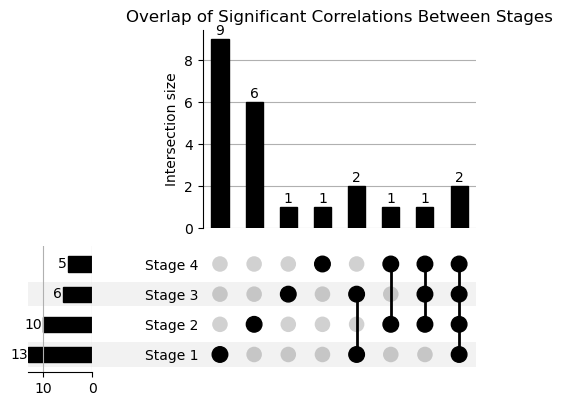

In [122]:
# Create sets of significant variable pairs for each stage
stage1_set = set(zip(stage1_df['Variable 1'], stage1_df['Variable 2']))
stage2_set = set(zip(stage2_df['Variable 1'], stage2_df['Variable 2']))
stage3_set = set(zip(stage3_df['Variable 1'], stage3_df['Variable 2']))
stage4_set = set(zip(stage4_df['Variable 1'], stage4_df['Variable 2']))

stage_sets = [stage1_set, stage2_set, stage3_set, stage4_set]

# Track the stages in which each variable pair appears
pair_stages_dict = {}
for stage_idx, stage_set in enumerate(stage_sets, start=1):
    for pair in stage_set:
        if pair not in pair_stages_dict:
            pair_stages_dict[pair] = []
        pair_stages_dict[pair].append(stage_idx)

# Group pairs by their stage combinations (e.g., Stage 1 & Stage 3)
common_pairs_grouped = {}
for pair, stages in pair_stages_dict.items():
    key = " & ".join([f"Stage {s}" for s in stages])
    if key not in common_pairs_grouped:
        common_pairs_grouped[key] = []
    common_pairs_grouped[key].append(pair)

# Convert results into a DataFrame format suitable for UpSet plot
UpSet_result_df = pd.DataFrame(
    [(key, pair) for key, pairs in common_pairs_grouped.items() for pair in pairs],
    columns=['Stages', 'Variable Pair']
)

# Create boolean columns for each stage
stages_list = ["Stage 1", "Stage 2", "Stage 3", "Stage 4"]
for stage in stages_list:
    UpSet_result_df[stage] = UpSet_result_df["Stages"].apply(lambda x: stage in x)

# Prepare boolean matrix as index for the UpSet plot
upset_data = UpSet_result_df.set_index(stages_list)

# Generate UpSet plot
from upsetplot import UpSet

upset_plot = UpSet(upset_data, subset_size="count", show_counts=True)
upset_plot.plot()
plt.title("Overlap of Significant Correlations Between Stages")
plt.show()


In [123]:
result_df

,Variable 1,Variable 2,Correlation,p_value,pTNM stage
0,zscore_log1p_Leu_ratio,zscore_log1p_Val_ratio,0.787281,1.375407e-05,1
1,zscore_log1p_Arg_ratio,zscore_log1p_Val_ratio,-0.593229,3.613365e-03,1
2,zscore_log1p_Leu_ratio,zscore_log1p_Lys_ratio,-0.613035,2.416644e-03,1
3,zscore_log1p_Ala_ratio,zscore_log1p_Leu_ratio,-0.650704,1.040846e-03,1
4,zscore_log1p_Orn_ratio,zscore_log1p_Phe_ratio,0.586560,4.114121e-03,1
5,zscore_log1p_Arg_ratio,zscore_log1p_Tau_ratio,-0.666879,6.997684e-04,1
6,zscore_log1p_Leu_ratio,zscore_log1p_Ser_ratio,-0.544890,8.733483e-03,1
7,zscore_log1p_Gly_ratio,zscore_log1p_Val_ratio,-0.606313,2.778257e-03,1
8,zscore_log1p_Lys_ratio,zscore_log1p_Ser_ratio,0.518736,1.337684e-02,1
9,zscore_log1p_Ser_ratio,zscore_log1p_Val_ratio,-0.590291,3.827287e-03,1


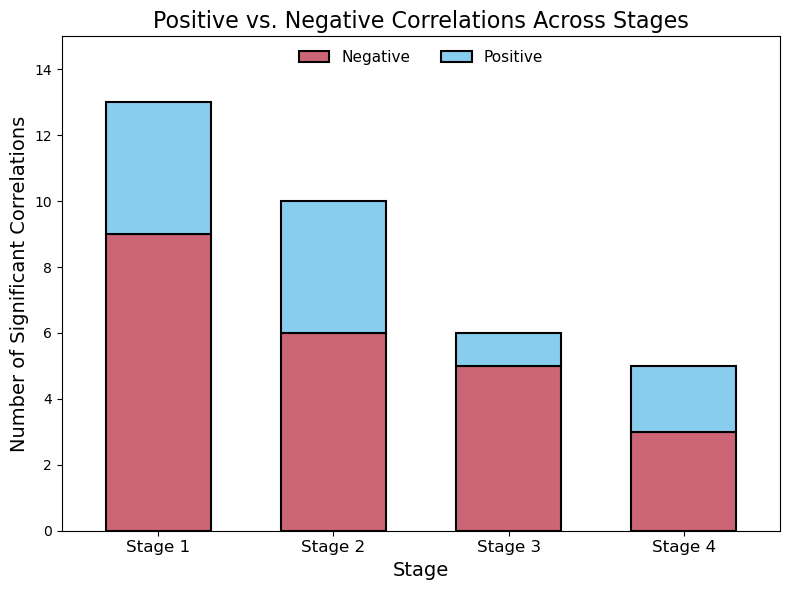

In [124]:
import pandas as pd
import matplotlib.pyplot as plt

# Add correlation sign (Positive or Negative)
result_df["Sign"] = result_df["Correlation"].apply(lambda x: "Positive" if x > 0 else "Negative")

# Count number of correlations by stage and sign
df_counts = result_df.groupby(["pTNM stage", "Sign"]).size().unstack(fill_value=0)

# Format stage labels for better readability
df_counts.index = [f"Stage {int(s)}" for s in df_counts.index]

# Create stacked bar plot
ax = df_counts.plot(
    kind="bar",
    stacked=True,
    color=["#CC6677", "#88CCEE"],  # Red for negative, blue for positive
    figsize=(8, 6),
    width=0.6,
)

# Add black borders to bars
for patch in ax.patches:
    patch.set_edgecolor("black")
    patch.set_linewidth(1.5)

# Set y-axis range with margin
max_y = df_counts.sum(axis=1).max()
plt.ylim(0, max_y + 2)

# Axis titles and ticks
plt.title("Positive vs. Negative Correlations Across Stages", fontsize=16)
plt.xlabel("Stage", fontsize=14)
plt.ylabel("Number of Significant Correlations", fontsize=14)
plt.xticks(rotation=0, fontsize=12)

# Legend configuration
plt.legend(
    fontsize=11,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.00),
    ncol=2,
    frameon=False
)

plt.tight_layout()
plt.show()


## Circos plot

In [125]:
def create_chord_diagram(stage_df, aa_list, stage_number):
    import numpy as np
    import pandas as pd
    import plotly.graph_objects as go

    # 1. Extract amino acid names and round correlation coefficients
    pair_data = [
        (
            var1.replace("zscore_log1p_", "").replace("_ratio", ""),
            var2.replace("zscore_log1p_", "").replace("_ratio", ""),
            round(corr, 2)
        )
        for var1, var2, corr in zip(stage_df["Variable 1"], stage_df["Variable 2"], stage_df["Correlation"])
    ]

    # 2. Initialize a symmetric matrix with zeros
    matrix = pd.DataFrame(0, index=aa_list, columns=aa_list)
    for a1, a2, val in pair_data:
        if a1 in matrix.index and a2 in matrix.columns:
            matrix.loc[a1, a2] = val
            matrix.loc[a2, a1] = val

    # 3. Compute circular coordinates for each amino acid node
    n = len(aa_list)
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    radius = 1
    node_coords = {
        aa: (radius * np.cos(ang), radius * np.sin(ang))
        for aa, ang in zip(aa_list, angles)
    }

    # 4. Add curves (edges) between correlated amino acids
    fig = go.Figure()
    for i, source in enumerate(aa_list):
        for j, target in enumerate(aa_list):
            val = matrix.loc[source, target]
            if val != 0 and i < j:  # avoid duplicate edges
                x0, y0 = node_coords[source]
                x1, y1 = node_coords[target]
                path = f"M {x0},{y0} Q 0,0 {x1},{y1}"
                color = "blue" if val > 0 else "red"
                width = 1 + 3 * abs(val)  # line thickness proportional to correlation
                fig.add_shape(
                    type="path",
                    path=path,
                    line=dict(color=color, width=width),
                    opacity=0.6,
                )

    # 5. Add nodes (amino acids) as labeled points on the circle
    node_x, node_y = zip(*[node_coords[aa] for aa in aa_list])
    fig.add_trace(go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers+text",
        marker=dict(size=20, color="lightgrey", line=dict(width=2, color="black")),
        text=aa_list,
        textposition="top center",
        hoverinfo="text"
    ))

    # 6. Final layout settings
    fig.update_layout(
        showlegend=False,
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        width=600,
        height=600,
        margin=dict(t=20, b=20, l=20, r=20),
        title=f"Stage {stage_number} Chord Diagram"
    )
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.show()


In [126]:
create_chord_diagram(stage1_df, amino_acids, 1)
create_chord_diagram(stage2_df, amino_acids, 2)
create_chord_diagram(stage3_df, amino_acids, 3)
create_chord_diagram(stage4_df, amino_acids, 4)


/tmp/ipykernel_216629/114941381.py:20: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.79' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_216629/114941381.py:21: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.79' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_216629/114941381.py:21: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.59' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_216629/114941381.py:20: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.61' has dtype incompatible with int64,

/tmp/ipykernel_216629/114941381.py:20: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.54' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_216629/114941381.py:21: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.54' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_216629/114941381.py:20: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.59' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_216629/114941381.py:21: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.59' has dtype incompatible with int64,

/tmp/ipykernel_216629/114941381.py:20: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.55' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_216629/114941381.py:21: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.55' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_216629/114941381.py:21: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.59' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_216629/114941381.py:20: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.51' has dtype incompatible with int6

/tmp/ipykernel_216629/114941381.py:20: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.71' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_216629/114941381.py:21: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.71' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_216629/114941381.py:21: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_216629/114941381.py:20: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.58' has dtype incompatible with int64, 

## Machine learning

In [127]:
# 1. Assign 'Yes' to patients in stage 4 (metastatic), otherwise 'No'
AA_df['Metastasis_Status'] = AA_df['pTNM stage'].apply(lambda x: 'Yes' if x == 4 else 'No')

# 2. Filter out patients in stage 1–3 whose recurrence status is missing (NaN)
cond = (AA_df['pTNM stage'].isin([1, 2, 3])) & (AA_df['Recurrence'].isna())
AA_df = AA_df[~cond].copy()  # Make a safe copy to avoid SettingWithCopyWarning

# 3. Create a new column combining both recurrence and metastasis status
AA_df.loc[:, 'Meta_or_Recur'] = AA_df.apply(
    lambda row: 'Yes' if row['Metastasis_Status'] == 'Yes' or row['Recurrence'] == 'Yes' else 'No',
    axis=1
)


In [128]:
AA_df

,Sample,Tau,Lys,Asn,Arg,Met,Gln,Orn,Phe,Leu,...,zscore_log1p_Arg_ratio,zscore_log1p_Gln_ratio,zscore_log1p_Gly_ratio,zscore_log1p_Tyr_ratio,zscore_log1p_Asn_ratio,zscore_log1p_Ala_ratio,zscore_log1p_Tau_ratio,zscore_log1p_Orn_ratio,Metastasis_Status,Meta_or_Recur
5,Patient-6,103.163,283.600,0.000,58.351,32.793,240.099,187.802,147.795,204.611,...,-0.218155,-2.221271,1.521212,-0.591776,-0.828894,0.265356,-0.780609,1.954275,Yes,Yes
6,Patient-7,219.484,268.823,0.000,0.000,0.000,153.435,318.059,145.300,419.063,...,-1.431875,-3.067604,0.004973,0.380593,-0.828894,0.690106,0.007100,3.229252,Yes,Yes
7,Patient-8,61.901,147.989,0.000,20.977,0.000,26.019,178.562,90.876,141.654,...,-0.770294,-3.704280,1.417475,0.057513,-0.828894,1.154950,-0.884669,3.456964,Yes,Yes
8,Patient-9,204.558,153.921,47.822,47.154,25.294,289.447,121.682,79.244,103.726,...,-0.075842,-1.096485,1.223665,0.094433,0.875547,0.014844,1.098929,1.592908,Yes,Yes
9,Patient-10,83.451,78.825,18.656,34.242,14.973,167.899,49.126,30.834,86.117,...,0.414146,-0.846875,0.334196,-0.751754,0.425530,-0.342863,0.423042,0.831817,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,Patient-148,124.315,172.431,0.000,58.213,28.906,367.515,103.372,77.159,144.639,...,0.160910,-0.526147,1.231598,-0.480444,-0.828894,0.571756,-0.134170,0.991169,No,Yes
148,Patient-149,152.506,131.335,43.920,29.851,27.922,415.112,118.936,64.782,120.672,...,-0.592291,-0.029226,1.112297,0.824704,0.697865,0.531368,0.301912,1.442654,Yes,Yes
149,Patient-150,119.279,207.649,90.775,62.947,51.336,678.529,93.942,64.417,107.694,...,-0.138229,0.689192,1.961577,0.569250,1.473895,-0.059298,-0.622682,0.165393,Yes,Yes
150,Patient-151,0.000,53.241,0.000,16.388,0.000,137.560,11.158,14.486,21.526,...,0.459556,1.295956,2.025068,-2.790035,-0.828894,0.440505,-1.904513,-0.423088,Yes,Yes


## Amino acid Only

[Ratio-only] Test AUROC: 0.736
[Ratio-only] Test PR-AUC: 0.762
[Ratio-only] Test F1-score: 0.692


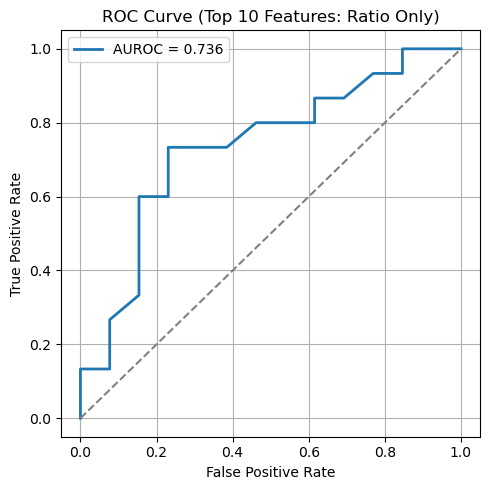

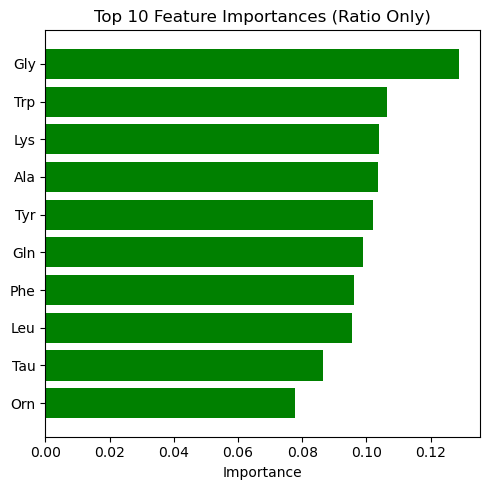

In [203]:
# 1) Use only amino acid ratio features
X_ratio = AA_df[zscore_columns]
y_ratio = AA_df['Meta_or_Recur'].map({'Yes': 1, 'No': 0})

# 2) Fit RF to select top 10 features
rf_ratio = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rf_ratio.fit(X_ratio, y_ratio)
importances_ratio = rf_ratio.feature_importances_
top10_ratio_features = X_ratio.columns[np.argsort(importances_ratio)[::-1][:10]]

X_final_ratio = X_ratio[top10_ratio_features].replace([np.inf, -np.inf], np.nan).dropna()
y_ratio = y_ratio.loc[X_final_ratio.index]

# 3) Split data
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_final_ratio, y_ratio, test_size=0.2, stratify=y_ratio, random_state=RANDOM_STATE
)

# 4) GridSearchCV tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'class_weight': ['balanced']
}
grid_r = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid, cv=5, scoring='roc_auc', n_jobs=-1
)
grid_r.fit(X_train_r, y_train_r)
best_model_r = grid_r.best_estimator_

# 5) Evaluate performance
y_pred_prob_r = best_model_r.predict_proba(X_test_r)[:, 1]
y_pred_class_r = best_model_r.predict(X_test_r)
roc_auc_r = roc_auc_score(y_test_r, y_pred_prob_r)
pr_auc_r = average_precision_score(y_test_r, y_pred_prob_r)
f1_r = f1_score(y_test_r, y_pred_class_r)

print(f"[Ratio-only] Test AUROC: {roc_auc_r:.3f}")
print(f"[Ratio-only] Test PR-AUC: {pr_auc_r:.3f}")
print(f"[Ratio-only] Test F1-score: {f1_r:.3f}")

# 6) Plot ROC Curve (Ratio-only)
fpr_r, tpr_r, _ = roc_curve(y_test_r, y_pred_prob_r)
plt.figure(figsize=(5, 5))
plt.plot(fpr_r, tpr_r, lw=2, label=f'AUROC = {roc_auc_r:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Top 10 Features: Ratio Only)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("RatioOnly_Feature_ROC.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# 7) Plot Feature Importance (Ratio-only)
feat_imp_r = best_model_r.feature_importances_
top10_clean_names = [
    name.replace("zscore_log1p_", "").replace("_ratio", "")
    for name in X_final_ratio.columns[np.argsort(feat_imp_r)[::-1]]
]

plt.figure(figsize=(5, 5))
plt.barh(
    top10_clean_names,
    feat_imp_r[np.argsort(feat_imp_r)[::-1]],
    color='green'
)
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (Ratio Only)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("RatioOnly_Feature_Importance.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()


In [204]:
from sklearn.utils import resample

n_iterations = 1000
boot_scores = []

for i in range(n_iterations):
    # Bootstrap sampling from test set
    X_resampled, y_resampled = resample(
        X_test_r, y_test_r,
        replace=True,
        stratify=y_test_r,
        random_state=RANDOM_STATE + i
    )
    # Predict probabilities
    y_prob_resampled = best_model_r.predict_proba(X_resampled)[:, 1]
    try:
        score = roc_auc_score(y_resampled, y_prob_resampled)
        boot_scores.append(score)
    except:
        continue  # skip failed iteration

# Convert to array and compute CI
boot_scores = np.array(boot_scores)
lower = np.percentile(boot_scores, 2.5)
upper = np.percentile(boot_scores, 97.5)

print(f"[Ratio-only] AUROC 95% CI (bootstrap, n={n_iterations}): [{lower:.3f}, {upper:.3f}]")


[Ratio-only] AUROC 95% CI (bootstrap, n=1000): [0.533, 0.908]


## Correlation Only

[Interaction-only] Test AUROC: 0.772
[Interaction-only] Test PR-AUC: 0.731
[Interaction-only] Test F1-score: 0.710


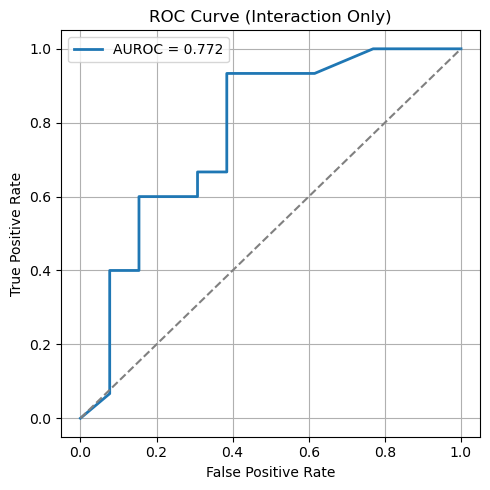

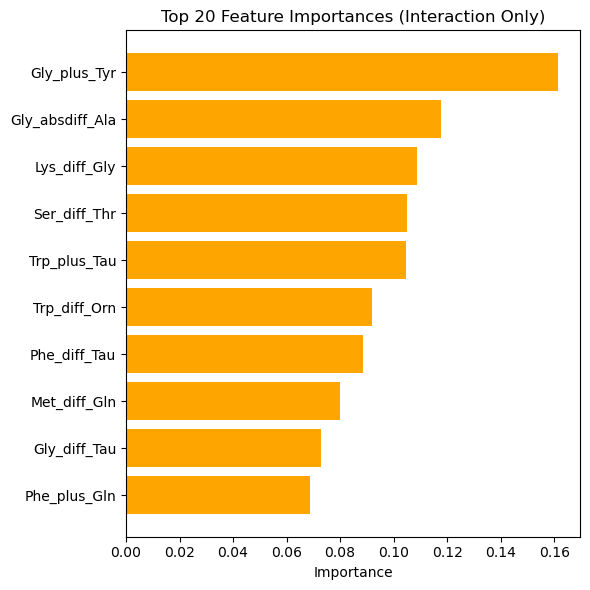

In [200]:
# 1) Prepare base data
X_base = AA_df[zscore_columns]
y_inter = AA_df['Meta_or_Recur'].map({'Yes': 1, 'No': 0})

# 2) Build interaction features (처음 100쌍까지만 계산)
inter_features = []
for i, (a, b) in enumerate(combinations(X_base.columns, 2)):
    inter_features.append((X_base[a] + X_base[b]).rename(f'{a}_plus_{b}'))
    inter_features.append((np.abs(X_base[a] - X_base[b])).rename(f'{a}_absdiff_{b}'))
    inter_features.append((X_base[a] - X_base[b]).rename(f'{a}_diff_{b}'))  # 이름 수정

X_interact_all = pd.concat(inter_features, axis=1).replace([np.inf, -np.inf], np.nan).dropna()
y_inter = y_inter.loc[X_interact_all.index]

# 3) Fit Random Forest to select top 20 interaction features
rf_inter = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rf_inter.fit(X_interact_all, y_inter)
inter_importances = rf_inter.feature_importances_
top20_inter_features = X_interact_all.columns[np.argsort(inter_importances)[::-1][:10]]

X_final_inter = X_interact_all[top20_inter_features]

# 4) Train/test split
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_final_inter, y_inter, test_size=0.2, stratify=y_inter, random_state=RANDOM_STATE
)

# 5) GridSearchCV for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'class_weight': ['balanced']
}
grid_i = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid, cv=5, scoring='roc_auc', n_jobs=-1
)
grid_i.fit(X_train_i, y_train_i)
best_model_i = grid_i.best_estimator_

# 6) Evaluation
y_pred_prob_i = best_model_i.predict_proba(X_test_i)[:, 1]
y_pred_class_i = best_model_i.predict(X_test_i)
roc_auc_i = roc_auc_score(y_test_i, y_pred_prob_i)
pr_auc_i = average_precision_score(y_test_i, y_pred_prob_i)
f1_i = f1_score(y_test_i, y_pred_class_i)

print(f"[Interaction-only] Test AUROC: {roc_auc_i:.3f}")
print(f"[Interaction-only] Test PR-AUC: {pr_auc_i:.3f}")
print(f"[Interaction-only] Test F1-score: {f1_i:.3f}")

# 7) ROC plot
fpr_i, tpr_i, _ = roc_curve(y_test_i, y_pred_prob_i)
plt.figure(figsize=(5, 5))
plt.plot(fpr_i, tpr_i, lw=2, label=f'AUROC = {roc_auc_i:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Interaction Only)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("InteractionOnly_Feature_ROC.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# 8) Feature importance plot
feat_imp_i = best_model_i.feature_importances_
top20_inter_names = X_final_inter.columns[np.argsort(feat_imp_i)[::-1]]

# prefix/suffix
clean_inter_names = [
    name.replace("zscore_log1p_", "").replace("_ratio", "")
    for name in top20_inter_names
]

plt.figure(figsize=(6, 6))
plt.barh(
    clean_inter_names,
    feat_imp_i[np.argsort(feat_imp_i)[::-1]],
    color='orange'
)
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances (Interaction Only)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("InteractionOnly_Feature_Importance.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()


In [201]:
from sklearn.utils import resample

n_iterations = 1000
boot_scores_i = []

for i in range(n_iterations):
    # Bootstrap 샘플링
    X_resampled_i, y_resampled_i = resample(
        X_test_i, y_test_i,
        replace=True,
        stratify=y_test_i,
        random_state=RANDOM_STATE + i
    )
    # 예측
    y_prob_resampled_i = best_model_i.predict_proba(X_resampled_i)[:, 1]
    try:
        score_i = roc_auc_score(y_resampled_i, y_prob_resampled_i)
        boot_scores_i.append(score_i)
    except:
        continue 

# Convert to array and compute CI
boot_scores_i = np.array(boot_scores_i)
lower_i = np.percentile(boot_scores_i, 2.5)
upper_i = np.percentile(boot_scores_i, 97.5)

print(f"[Interaction-only] AUROC 95% CI (bootstrap, n={n_iterations}): [{lower_i:.3f}, {upper_i:.3f}]")


[Interaction-only] AUROC 95% CI (bootstrap, n=1000): [0.579, 0.933]


## Combined 

Test AUROC: 0.803
Test PR-AUC: 0.809
Test F1-score: 0.733


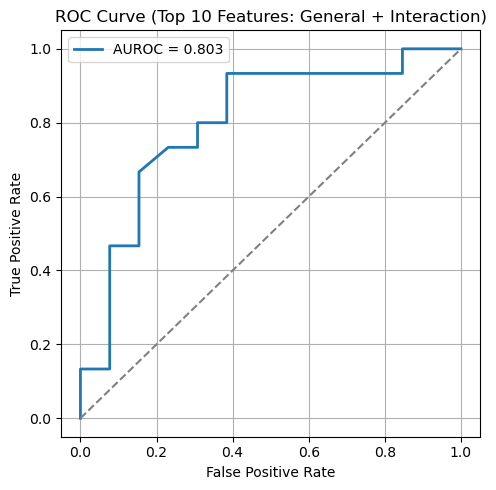

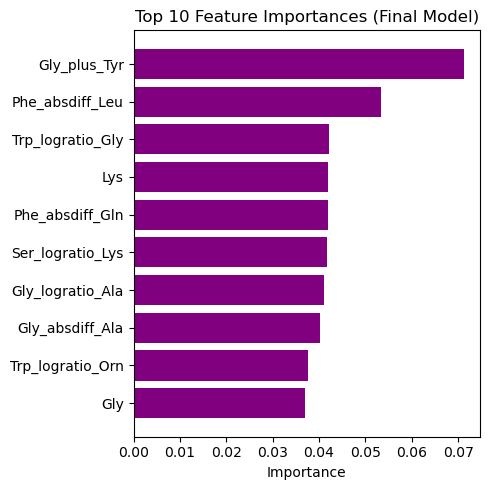

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, f1_score
from sklearn.preprocessing import StandardScaler

# Set random seed
RANDOM_STATE = 42

# Prepare feature matrix X and binary target y
X = AA_df[zscore_columns]
y = AA_df['Meta_or_Recur'].map({'Yes': 1, 'No': 0})

# 1) Fit RF on general amino acid ratios
rf_temp = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rf_temp.fit(X, y)
importances = rf_temp.feature_importances_
selected_ratio_features = X.columns[np.argsort(importances)[::-1][:10]]

# 2) Build interaction features for first 100 pairs
inter_features = []
for a, b in combinations(X.columns, 2):
    inter_features.append((X[a] + X[b]).rename(f'{a}_plus_{b}'))
    inter_features.append((np.abs(X[a] - X[b])).rename(f'{a}_absdiff_{b}'))
    inter_features.append((X[a] - X[b]).rename(f'{a}_logratio_{b}'))
X_interact_all = pd.concat(inter_features, axis=1).replace([np.inf, -np.inf], np.nan).dropna()

# 3) Fit RF on interaction features
rf_inter = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rf_inter.fit(X_interact_all, y)
inter_importances = rf_inter.feature_importances_
selected_interaction_features = X_interact_all.columns[np.argsort(inter_importances)[::-1][:20]]

# 4) Merge top features and clean data
X_final = pd.concat([
    X[selected_ratio_features],
    X_interact_all[selected_interaction_features]
], axis=1).replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X_final.index]

# 5) Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# 6) Tune Random Forest with grid search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'class_weight': ['balanced']
}
grid = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid, cv=5, scoring='roc_auc', n_jobs=-1
)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

# 7) Evaluate model performance
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_pred_class = best_model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)
f1 = f1_score(y_test, y_pred_class)

print(f"Test AUROC: {roc_auc:.3f}")
print(f"Test PR-AUC: {pr_auc:.3f}")
print(f"Test F1-score: {f1:.3f}")

# 8) Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, lw=2, label=f'AUROC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Top 10 Features: General + Interaction)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Combined_Feature_ROC.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# 9) Plot final model's top 10 feature importances (clean labels)
feat_imp = best_model.feature_importances_
top10_final = X_final.columns[np.argsort(feat_imp)[::-1][:10]]

# Clean feature names
clean_final_names = [
    name.replace("zscore_log1p_", "").replace("_ratio", "")
    for name in top10_final
]

plt.figure(figsize=(5, 5))
plt.barh(
    clean_final_names,
    feat_imp[np.argsort(feat_imp)[::-1][:10]],
    color='purple'
)
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (Final Model)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("Combined_Feature_Importance.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()



In [205]:
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
import numpy as np

# Set bootstrap parameters
n_iterations = 1000
boot_scores = []

# Bootstrap resampling
for i in range(n_iterations):
    X_resampled, y_resampled = resample(
        X_test, y_test,
        replace=True,
        stratify=y_test,
        random_state=RANDOM_STATE + i
    )
    y_prob_resampled = best_model.predict_proba(X_resampled)[:, 1]
    try:
        auc = roc_auc_score(y_resampled, y_prob_resampled)
        boot_scores.append(auc)
    except ValueError:
        continue  # Skip if only one class in y_resampled

# Compute confidence interval
boot_scores = np.array(boot_scores)
lower = np.percentile(boot_scores, 2.5)
upper = np.percentile(boot_scores, 97.5)

print(f"Bootstrap AUROC 95% CI: [{lower:.3f}, {upper:.3f}]")


Bootstrap AUROC 95% CI: [0.618, 0.956]


In [191]:
from sklearn.metrics import confusion_matrix

epsilon = 1e-8
# Sensitivity, Specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_class).ravel()

sensitivity = tp / (tp + fn + epsilon) 
specificity = tn / (tn + fp + epsilon)  

print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")


Sensitivity (Recall): 0.733
Specificity: 0.692
